# Data Preparation

In [76]:
import os 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from ipynb.fs.full.Utils import loadDataFrames

In [3]:
def deleteOutliersByField(df, field):
    iqr = 1.5 * (np.percentile(df[field], 75)) - (np.percentile(df[field], 25))
    greaterThan75 = df[df[field] > (iqr + np.percentile(df[field], 75))]
    print('amount of rows to delete greater than 75' , len(greaterThan75))
    lesserThan25 = df[df[field] < (np.percentile(df[field], 25) - iqr )]
    print('amount of rows to delete lesser than 25' , len(lesserThan25))
    df.drop(greaterThan75.index, inplace = True)
    df.drop(lesserThan25.index, inplace = True)
    
def printNewShapeDF(df):
    print('::: New Shape Dataframe', df.shape)
    
def getRenameObject(enc, columnNames):
    encodedFeaturesNames = enc.get_feature_names_out(columnNames)
    columns = {}
    for i in range(0,len(encodedFeaturesNames)):
        columns[i] = encodedFeaturesNames[i]
    return columns, encodedFeaturesNames

## Cleaning Data

In [79]:
spotifyFeatures, transitionMatrices, df = loadDataFrames()

In [80]:
print('spotifyFeatures len :', len(spotifyFeatures))
print('transitionMatrices len :', len(transitionMatrices))

spotifyFeatures len : 3484
transitionMatrices len : 3482


In [81]:
df[df.duplicated(subset=['id_track'])]

,id_spotify_track,id_track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,1276,1278,1281,1286,1287,1288,1290,1292,1294,1295
id,,,,,,,,,,,,,,,,,,,,,


In [82]:
len(df.columns.tolist())

678

In [83]:
s = df.nunique(axis=0)
s[s < 15].index

Index(['key', 'mode', 'time_signature', 'mood', '2', '4', '8', '9', '13', '16',
       ...
       '1267', '1271', '1275', '1276', '1278', '1286', '1288', '1290', '1294',
       '1295'],
      dtype='object', length=431)

## Removing useless columns

In [16]:
df = df.drop(['id_spotify_track', 'id_track', 'popularity', 'duration_ms', 'release_date', 'name', 'album_name'], axis=1)

In [17]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,1276,1278,1281,1286,1287,1288,1290,1292,1294,1295
id,,,,,,,,,,,,,,,,,,,,,
23,0.494,0.756,7,-8.504,1,0.0432,0.001400,0.005200,0.1640,0.589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.582,0.744,7,-9.155,1,0.0336,0.000458,0.001320,0.0405,0.674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,0.614,0.755,2,-5.829,1,0.0276,0.016200,0.000002,0.0831,0.645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,0.319,0.807,11,-6.504,0,0.0388,0.001040,0.290000,0.1310,0.601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
292,0.496,0.527,6,-7.234,1,0.0339,0.195000,0.000000,0.1380,0.283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check columns with low variance

# (?) Check whether its better to apply outliers techniques, although this logic is being infered from descriptions and data

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

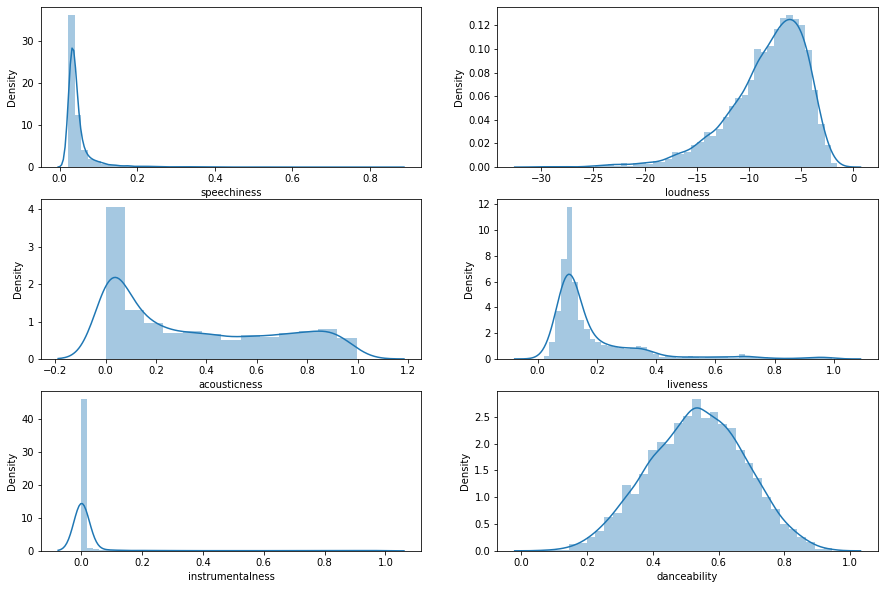

In [63]:
plt.figure(figsize=(15,10))

# Plot distribution of var1
plt.subplot(3, 2, 1); 

sns.distplot(df['speechiness'])

plt.subplot(3,2,2)
sns.distplot(df['loudness'])

# Plot distribution of var2
plt.subplot(3, 2, 3);
sns.distplot(df['acousticness'])

plt.subplot(3, 2, 4);
sns.distplot(df['liveness'])

plt.subplot(3, 2, 5);
sns.distplot(df['instrumentalness'])

plt.subplot(3, 2, 6); 
sns.distplot(df['danceability'])

plt.show()

<AxesSubplot:xlabel='instrumentalness', ylabel='Density'>

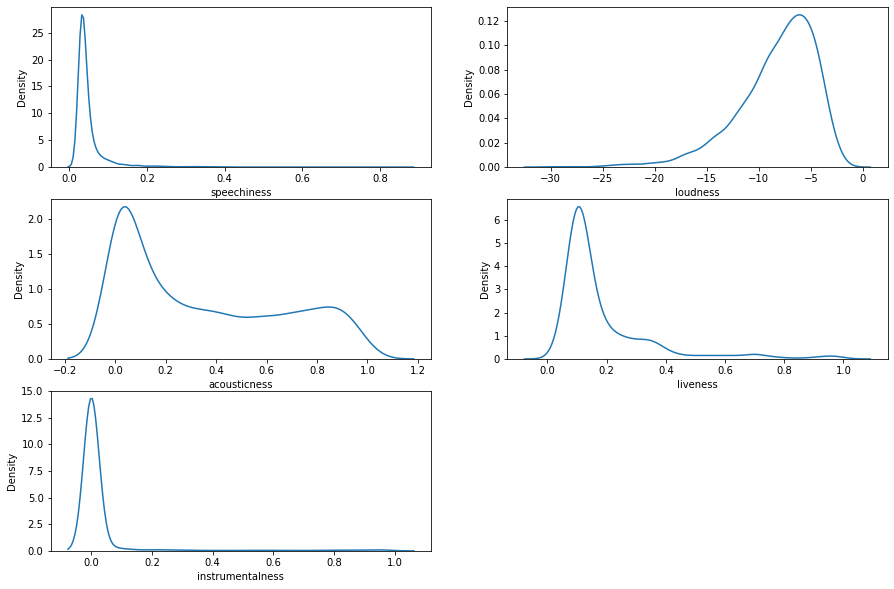

In [75]:
plt.figure(figsize=(15,10))

# Plot distribution of var1
plt.subplot(3, 2, 1); 
sns.kdeplot(data=df, x="speechiness")

plt.subplot(3,2,2)
sns.kdeplot(data=df, x="loudness")

# Plot distribution of var2
plt.subplot(3, 2, 3);
sns.kdeplot(data=df, x="acousticness")

plt.subplot(3, 2, 4);
sns.kdeplot(data=df, x="liveness")

plt.subplot(3, 2,5);
sns.kdeplot(data=df, x="instrumentalness")





## Droppping outliers on speechiness

One way to do it would be to rely merely on the data understanding too.
df = df.loc[df.speechiness <= 0.33]

<font color="blue"> 
Since values below 0.33 most likely represent music and other non-speech-like tracks, and only 18 rows have values greater than 0.33, it was decided to cut rows above the 0.33 range, that are more likely to have only speech.
</font>

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


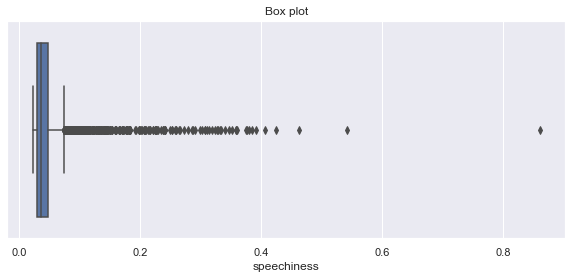

In [686]:

plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.speechiness)
plt.show()

<Figure size 720x288 with 0 Axes>

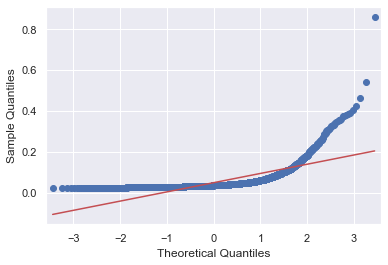

In [687]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(10,4))
qqplot(df.speechiness, line='s')
plt.show()

<font color="blue"> 
As it can be seen data is not falling into the red reference line what means that data is not normally distributed
</font>

In [688]:
deleteOutliersByField(df, 'speechiness')
printNewShapeDF(df)

amount of rows to delete greater than 75 293
amount of rows to delete lesser than 25 0
::: New Shape Dataframe (3189, 670)


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


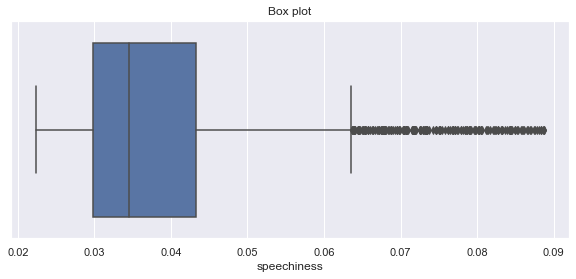

In [689]:

plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.speechiness)
plt.show()

## Droppping outliers on loudness

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


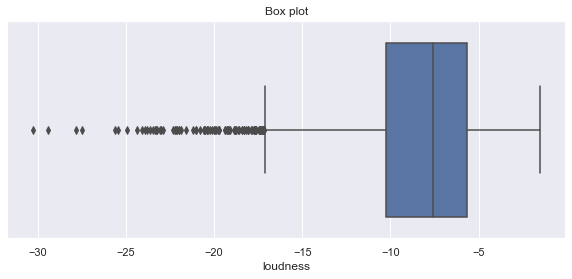

In [690]:
plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.loudness)
plt.show()

<Figure size 720x288 with 0 Axes>

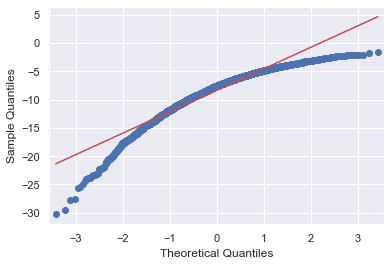

In [691]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(10,4))
qqplot(df.loudness, line='s')
plt.show()

<font color="blue"> 
If loudness is dropped the size of the dataframe is significantly affected ::: New Shape Dataframe (2521, 672),  and considering energy and loudness are strongly negatively correlated,
the most likely to happen is that loudness will dissapear in feature selection.
</font>

## instrumentalness highly skewed

https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45
    https://towardsdatascience.com/avoid-mistakes-in-machine-learning-models-with-skewed-count-data-e3512b94d745

<font color="blue"> 
Since Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. and those are postive skewed, it makes sense to keep only values where theres vocal, the closer to 1 it means they are purely vocal like Rap. So we want to keep vocal and instrumentalness.
</font>

<Figure size 720x288 with 0 Axes>

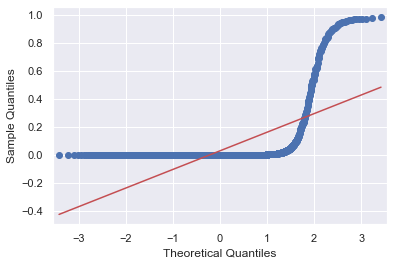

In [692]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(10,4))
qqplot(df.instrumentalness, line='s')
plt.show()

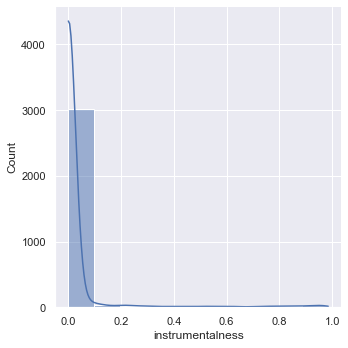

In [693]:
 sns.displot(data=df, x="instrumentalness", kde=True, bins=10)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


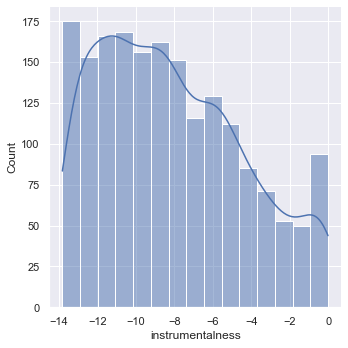

In [694]:
instru = df.instrumentalness 
instrumentalness_log =  np.log(instru)
sns.displot(instrumentalness_log, kde=True)
plt.show()

In [695]:
instrumentalness_log.min()

-inf

### Skewness instrumentalness

In [696]:
print('skewness before log',  df.instrumentalness.skew())

skewness before log 5.493620141511423


In [697]:
totalRows = len(df.instrumentalness)
range1 = len(df.instrumentalness[df.instrumentalness < 0.5])
range2 = len(df.instrumentalness[df.instrumentalness > 0.5])
print('less than 0.5', range1/totalRows , range1)
print('over than 0.5', range2/totalRows, range2)

less than 0.5 0.9746001881467544 3108
over than 0.5 0.02539981185324553 81


<font color="blue"> 
Since Values below 0.5 represent almost the 98% or observations a binning approach has been decided, since logarithm approach was not appropiate in this case
</font>

### Hot Encoding Categorical features

In [698]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence',
       ...
       '1276', '1278', '1281', '1286', '1287', '1288', '1290', '1292', '1294',
       '1295'],
      dtype='object', length=670)

In [699]:
# changing types 
categoricalFeatures = ['key', 'time_signature', 'mode', 'mood']
df = df.astype({"key": int,"time_signature": int, "mode": int, "mood": int })

<AxesSubplot:xlabel='mood', ylabel='Count'>

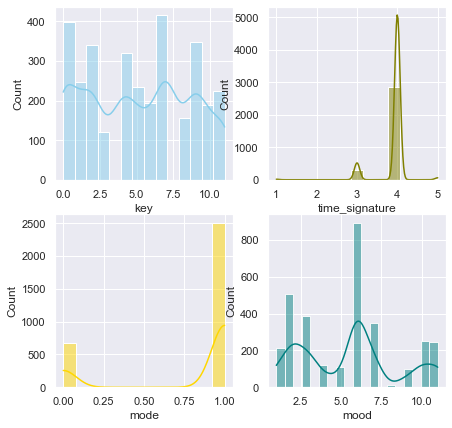

In [700]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data=df, x="key", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="time_signature", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="mode", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df, x="mood", kde=True, color="teal", ax=axs[1, 1])

In [701]:
categDF = df[categoricalFeatures]

In [702]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categDF)
OneHotEncoder(handle_unknown='ignore')

OneHotEncoder(handle_unknown='ignore')

In [703]:
enc.categories_


[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([1, 3, 4, 5]),
 array([0, 1]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])]

In [704]:
hotEncodedCatFeatures = pd.DataFrame(enc.transform(categDF).toarray())

In [705]:
hotEncodedCatFeatures.head(1)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [706]:
hotEncodedCatFeatures.head(1)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [707]:
c, encodedFeaturesNames  = getRenameObject(enc, ['key', 'time_signature', 'mode', 'mood'])
hotEncodedCatFeatures = hotEncodedCatFeatures.rename(columns=c)

In [708]:
hotEncodedCatFeatures.head(1)

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,mood_2,mood_3,mood_4,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [709]:
df = pd.concat([df.reset_index(), hotEncodedCatFeatures], axis=1)

In [710]:
df.head(1)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,mood_2,mood_3,mood_4,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11
0,23,0.494,0.756,7,-8.504,1,0.0432,0.0014,0.0052,0.164,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Dropping ID column

In [711]:
df = df.drop(['id','key', 'time_signature', 'mode', 'mood'], axis=1)

In [712]:
os.makedirs('./data', exist_ok=True)  
df.to_csv('./data/05-RawData.csv')

## Key k-means assumptions

**Key steps**
- Symmetric distribution of variables (not skewed)
- Variables with same average values: This is key to ensure that each metric gets an equeal weight in the knn calculation.
- Variables with same variance: It helps the algorithm to converge and ensures equal importance, it is assigned to each variable
- Equal mean and variance

## Centering and scaling variables

K-means works well on variables with the same mean

#### Variables on the same scale

In [713]:
skipScalingFeatures = df[encodedFeaturesNames.tolist()]

In [714]:
skipScalingFeatures.head(1)

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,mood_2,mood_3,mood_4,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [715]:
featuresToScale = df.drop(encodedFeaturesNames.tolist(), axis=1)

In [716]:
featuresToScale.head(1)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,0,...,1276,1278,1281,1286,1287,1288,1290,1292,1294,1295
0,0.494,0.756,-8.504,0.0432,0.0014,0.0052,0.164,0.589,133.337,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [717]:
featuresToScale.columns.tolist()

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 '0',
 '1',
 '2',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '26',
 '27',
 '28',
 '29',
 '30',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '39',
 '41',
 '42',
 '43',
 '45',
 '47',
 '50',
 '51',
 '52',
 '54',
 '56',
 '57',
 '58',
 '60',
 '62',
 '63',
 '64',
 '66',
 '69',
 '71',
 '72',
 '74',
 '78',
 '83',
 '87',
 '93',
 '99',
 '108',
 '111',
 '113',
 '114',
 '119',
 '120',
 '123',
 '124',
 '126',
 '129',
 '132',
 '135',
 '141',
 '143',
 '144',
 '155',
 '156',
 '159',
 '170',
 '180',
 '181',
 '185',
 '186',
 '187',
 '188',
 '189',
 '191',
 '192',
 '194',
 '195',
 '196',
 '197',
 '200',
 '201',
 '202',
 '204',
 '206',
 '207',
 '208',
 '209',
 '210',
 '212',
 '213',
 '214',
 '215',
 '216',
 '217',
 '219',
 '221',
 '222',
 '223',
 '224',
 '225',
 '227',
 '228',
 '230',
 '231',
 '2

In [718]:
#featuresToScale_centered = featuresToScale - featuresToScale.mean()
#featuresToScale_centered.describe().round(2)

##### Scaling variables with different variance

In [719]:
std_scale = StandardScaler().fit(featuresToScale_centered)
df_normalized = std_scale.transform(featuresToScale_centered)

In [720]:
centeredScaledDF = pd.DataFrame(df_std)

In [721]:
centeredScaledDF.describe()

,0,1,2,3,4,5,6,7,8,9,...,656,657,658,659,660,661,662,663,664,665
count,3189.000000,3.189000e+03,3189.000000,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,...,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03
mean,0.000000,4.233400e-17,0.000000,4.010589e-17,-3.342158e-17,3.342158e-17,1.782484e-17,8.912421e-18,3.564968e-17,-2.673726e-17,...,4.456210e-18,-1.169755e-17,3.564968e-17,-8.912421e-18,-2.228105e-18,2.228105e-18,1.225458e-17,6.684315e-18,8.912421e-18,3.899184e-18
std,1.000157,1.000157e+00,1.000157,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,...,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00
min,-3.085729,-2.435724e+00,-5.776326,-1.265272e+00,-1.095524e+00,-2.202793e-01,-1.016376e+00,-1.754089e+00,-2.671123e+00,-5.026735e-01,...,-2.268163e-02,-3.478239e-02,-9.962325e-02,-1.771091e-02,-5.784657e-02,-1.771091e-02,-1.771091e-02,-4.736601e-02,-1.771091e-02,-3.892479e-02
25%,-0.697202,-7.791834e-01,-0.496964,-6.905435e-01,-9.483495e-01,-2.202793e-01,-5.319322e-01,-8.085181e-01,-8.108215e-01,-5.026735e-01,...,-2.268163e-02,-3.478239e-02,-9.962325e-02,-1.771091e-02,-5.784657e-02,-1.771091e-02,-1.771091e-02,-4.736601e-02,-1.771091e-02,-3.892479e-02
50%,0.027661,1.534180e-02,0.201790,-3.255131e-01,-3.036845e-01,-2.202495e-01,-4.003240e-01,-1.708585e-01,2.962515e-03,-5.026735e-01,...,-2.268163e-02,-3.478239e-02,-9.962325e-02,-1.771091e-02,-5.784657e-02,-1.771091e-02,-1.771091e-02,-4.736601e-02,-1.771091e-02,-3.892479e-02
75%,0.710299,8.098670e-01,0.715456,3.579482e-01,9.011806e-01,-2.176631e-01,1.010405e-01,6.939127e-01,6.849511e-01,3.212300e-02,...,-2.268163e-02,-3.478239e-02,-9.962325e-02,-1.771091e-02,-5.784657e-02,-1.771091e-02,-1.771091e-02,-4.736601e-02,-1.771091e-02,-3.892479e-02
max,2.927111,1.965946e+00,1.796498,3.883987e+00,1.997359e+00,7.206222e+00,5.070817e+00,2.371045e+00,3.170862e+00,9.627900e+00,...,5.309460e+01,4.008389e+01,1.775090e+01,5.646238e+01,4.280605e+01,5.646238e+01,5.646238e+01,4.496088e+01,5.646238e+01,3.205948e+01


In [722]:
print('mean: ', df_normalized.mean(axis=0).round(2))
print('std: ', df_normalized.std(axis=0).round(2))

mean:  [ 0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0.  0. -0.  0. -0.  0.  0. -0.
  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0.  0.  0. -0. -0.  0.
 -0.  0.  0.  0. -0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0. -0.  0.
  0.  0.  0.  0.  0. -0.  0. -0.  0.  0. -0.  0.  0.  0. -0.  0.  0. -0.
  0.  0. -0. -0. -0. -0. -0.  0. -0.  0. -0.  0. -0.  0. -0. -0. -0. -0.
  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0. -0. -0.
 -0.  0.  0. -0.  0.  0.  0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0.
  0. -0.  0. -0.  0. -0.  0. -0. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0.
 -0. -0. -0.  0. -0. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0.
  0. -0.  0.  0. -0. -0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0. -0.
 -0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0. -0.  0. -0.  0.  0. -0.  0.
 -0.  0.  0. -0. -0. -0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.
 -0.  0.  0. -0. -0.  0.  0.  0.  0. -0. -0.  0. -0.  0. -0. -0. -0. -0.
 -0.  0.  0. -0.  0. -0.  0.  0.  0. -0.  0.

In [723]:
df = pd.concat([centeredScaledDF, skipScalingFeatures], axis=1)

In [724]:
df

,0,1,2,3,4,5,6,7,8,9,...,mood_2,mood_3,mood_4,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11
0,-0.253839,0.930385,-0.040431,0.350182,-1.091194,-0.181073,-0.112039,0.667707,0.469546,-0.502673,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.365461,0.876821,-0.211828,-0.395412,-1.094120,-0.210327,-0.886021,1.038948,0.469790,2.072273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.590661,0.925921,0.663853,-0.861409,-1.045236,-0.220265,-0.619044,0.912289,-0.950043,-0.502673,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.485402,1.158030,0.486136,0.008451,-1.092312,1.966203,-0.318852,0.720118,-0.061819,-0.093711,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.239764,-0.091785,0.293939,-0.372113,-0.490004,-0.220279,-0.274983,-0.668757,1.257354,-0.309553,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,0.428799,0.966094,0.754685,0.746278,-0.976608,-0.220279,-0.494330,0.182912,1.745346,-0.502673,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3185,0.062848,-0.176594,0.605667,-0.768210,1.162028,-0.220279,-0.049369,-0.913339,-0.645450,0.159455,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3186,0.801786,-1.038074,-0.271594,-0.372113,1.096816,-0.208065,-0.536946,-0.349927,-2.087423,-0.502673,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3187,0.520286,-0.810429,0.218903,-0.814809,0.699335,-0.220279,-0.306318,-1.336989,0.770932,-0.502673,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [725]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,mood_2,mood_3,mood_4,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11
count,3189.000000,3.189000e+03,3189.000000,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,3.189000e+03,...,3189.000000,3189.000000,3189.000000,3189.000000,3189.000000,3189.000000,3189.000000,3189.000000,3189.000000,3189.000000
mean,0.000000,4.233400e-17,0.000000,4.010589e-17,-3.342158e-17,3.342158e-17,1.782484e-17,8.912421e-18,3.564968e-17,-2.673726e-17,...,0.159298,0.120414,0.038570,0.035121,0.280025,0.108812,0.003136,0.031671,0.079335,0.077140
std,1.000157,1.000157e+00,1.000157,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,...,0.366011,0.325496,0.192598,0.184114,0.449082,0.311451,0.055919,0.175151,0.270304,0.266856
min,-3.085729,-2.435724e+00,-5.776326,-1.265272e+00,-1.095524e+00,-2.202793e-01,-1.016376e+00,-1.754089e+00,-2.671123e+00,-5.026735e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.697202,-7.791834e-01,-0.496964,-6.905435e-01,-9.483495e-01,-2.202793e-01,-5.319322e-01,-8.085181e-01,-8.108215e-01,-5.026735e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.027661,1.534180e-02,0.201790,-3.255131e-01,-3.036845e-01,-2.202495e-01,-4.003240e-01,-1.708585e-01,2.962515e-03,-5.026735e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.710299,8.098670e-01,0.715456,3.579482e-01,9.011806e-01,-2.176631e-01,1.010405e-01,6.939127e-01,6.849511e-01,3.212300e-02,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.927111,1.965946e+00,1.796498,3.883987e+00,1.997359e+00,7.206222e+00,5.070817e+00,2.371045e+00,3.170862e+00,9.627900e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [726]:
os.makedirs('./data', exist_ok=True)  
df.to_csv('./data/05-DataPrepared.csv')

In [727]:
df

,0,1,2,3,4,5,6,7,8,9,...,mood_2,mood_3,mood_4,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11
0,-0.253839,0.930385,-0.040431,0.350182,-1.091194,-0.181073,-0.112039,0.667707,0.469546,-0.502673,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.365461,0.876821,-0.211828,-0.395412,-1.094120,-0.210327,-0.886021,1.038948,0.469790,2.072273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.590661,0.925921,0.663853,-0.861409,-1.045236,-0.220265,-0.619044,0.912289,-0.950043,-0.502673,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.485402,1.158030,0.486136,0.008451,-1.092312,1.966203,-0.318852,0.720118,-0.061819,-0.093711,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.239764,-0.091785,0.293939,-0.372113,-0.490004,-0.220279,-0.274983,-0.668757,1.257354,-0.309553,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,0.428799,0.966094,0.754685,0.746278,-0.976608,-0.220279,-0.494330,0.182912,1.745346,-0.502673,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3185,0.062848,-0.176594,0.605667,-0.768210,1.162028,-0.220279,-0.049369,-0.913339,-0.645450,0.159455,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3186,0.801786,-1.038074,-0.271594,-0.372113,1.096816,-0.208065,-0.536946,-0.349927,-2.087423,-0.502673,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3187,0.520286,-0.810429,0.218903,-0.814809,0.699335,-0.220279,-0.306318,-1.336989,0.770932,-0.502673,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
